In [1]:

import tensorflow as tf
import numpy as np
import random
import os

In [2]:
# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow


In [3]:
# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms


In [4]:
# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [5]:
# import os
import scipy.io #to load matlab files 
# import numpy as np
from sklearn.model_selection import train_test_split #for data splitting #, KFold
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from tensorflow.keras import layers, models #build and train CNN model
import matplotlib.pyplot as plt #for plotting confusion matrices and accuracy metrics
import seaborn as sns 
# import pandas as pd

from scipy import signal #for computing spectograms
from skimage.transform import resize #for resizing data
from sklearn.model_selection import StratifiedKFold

In [6]:
"""
# -----------------------------------------------------------------------------
# Read CWRU Bearing Data (Load - 2HP)
# -----------------------------------------------------------------------------
"""
def ImportData():
  folder_path = 'CWRU_BearingData_Load_2HP' 
  # X99_normal = scipy.io.loadmat('content/drive/MyDrive/BearingData_CaseWestern/99.mat')['X099_DE_time'] 
  file_path1 = os.path.join(folder_path, '99.mat')
  X99_normal = scipy.io.loadmat(file_path1)['X099_DE_time'] #vibration data extracted from X099_DE_time key (drive-end accelerometer data)

    
  # X111_InnerRace_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/111.mat')['X111_DE_time']
  file_path2 = os.path.join(folder_path, '111.mat')
  X111_InnerRace_007  = scipy.io.loadmat(file_path2)['X111_DE_time']

  # X124_Ball_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/124.mat')['X124_DE_time']
  file_path3 = os.path.join(folder_path, '124.mat')
  X124_Ball_007 = scipy.io.loadmat(file_path3)['X124_DE_time']

  # X137_Outer_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/137.mat')['X137_DE_time']
  file_path4 = os.path.join(folder_path, '137.mat')
  X137_Outer_007 = scipy.io.loadmat(file_path4)['X137_DE_time']
    
  # X176_InnerRace_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/176.mat')['X176_DE_time']
  file_path5 = os.path.join(folder_path, '176.mat')
  X176_InnerRace_014 = scipy.io.loadmat(file_path5)['X176_DE_time']

  # X191_Ball_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/191.mat')['X191_DE_time']
  file_path6 = os.path.join(folder_path, '191.mat')
  X191_Ball_014 = scipy.io.loadmat(file_path6)['X191_DE_time']
    
  # X203_Outer_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/203.mat')['X203_DE_time']
  file_path7 = os.path.join(folder_path, '203.mat')
  X203_Outer_014  = scipy.io.loadmat(file_path7)['X203_DE_time']

  #  X215_InnerRace_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/215.mat')['X215_DE_time']
  file_path8 = os.path.join(folder_path, '215.mat')
  X215_InnerRace_021  = scipy.io.loadmat(file_path8)['X215_DE_time']
    
  # X228_Ball_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/228.mat')['X228_DE_time']
  file_path9 = os.path.join(folder_path, '228.mat')
  X228_Ball_021  = scipy.io.loadmat(file_path9)['X228_DE_time']

  # X240_Outer_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/240.mat')['X240_DE_time']
  file_path10 = os.path.join(folder_path, '240.mat')
  X240_Outer_021  = scipy.io.loadmat(file_path10)['X240_DE_time'] 
  
    
  return [X99_normal,X111_InnerRace_007,X124_Ball_007,X137_Outer_007,X176_InnerRace_014,X191_Ball_014,X203_Outer_014,X215_InnerRace_021,X228_Ball_021,X240_Outer_021]

In [7]:
"""
# -----------------------------------------------------------------------------
# Data Processing and Feature Extraction
# -----------------------------------------------------------------------------
"""
# def Sampling(Data, interval_length, samples_per_block):
#     No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length) - 1)
#     SplitData = np.zeros([No_of_blocks, samples_per_block])
#     for i in range(No_of_blocks):
#         SplitData[i,:] = Data[i*interval_length:(i*interval_length)+samples_per_block].T
#     return SplitData

#segments the time-series data into smaller blocks for processing
#data: 1D numpy array of vibration data
#interval length: step size (in samples) betweeen the start of consectuive blocks
#samples_per_block: no. of samples in each block (fixed at 1600 in the code)
#ignore_points: no. of points to skip at start and end of data(default is 0)
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    # Adjust data length to ignore the first and last 'ignore_points'
    adjusted_length = len(Data) - 2 * ignore_points
    # Adjust the number of blocks
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block]) #splitdata matrix where each row is a block of samples_per_block samples
    
    for i in range(No_of_blocks):
        # Skip the first 'ignore_points' and start sampling from that position
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T #.T transpose ensure the data is correctly oriented (since the input is a column vector)
    
    return SplitData #2D array of shape - no.ofblocks, samples_per_block)


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block) #for each dataset calls samplying to create blocks of 1600 samples
    y = np.zeros([len(SplitData),10]) #y (one-hot encoded): Shape (No_of_blocks, 10), where the column corresponding to the class is set to 1 (e.g., for class 0, [1, 0, 0, ..., 0])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1]) #y1 (integer labels): Shape (No_of_blocks, 1), where each element is the class index (0 to 9).
    y1[:,0] = count 
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  print(X)
  return X, LabelPositional, Label

In [8]:
Data = ImportData()
for i, d in enumerate(Data):
    print(f"Dataset {i+1} shape: {d.shape}")
    
interval_length = 1600 #320 #290 #200  
samples_per_block = 1296 #1600 #1650-25*2


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

# XX = {'X':X}
# scipy.io.savemat('Data.mat', XX)


Dataset 1 shape: (485063, 1)
Dataset 2 shape: (485643, 1)
Dataset 3 shape: (486804, 1)
Dataset 4 shape: (486804, 1)
Dataset 5 shape: (487964, 1)
Dataset 6 shape: (487384, 1)
Dataset 7 shape: (486804, 1)
Dataset 8 shape: (491446, 1)
Dataset 9 shape: (487384, 1)
Dataset 10 shape: (487964, 1)
[[ 0.06425354  0.06300185 -0.00438092 ... -0.029832   -0.018984
  -0.002712  ]
 [ 0.08615815  0.06446215  0.06154154 ... -0.07238954 -0.024408
  -0.02086154]
 [-0.02712    -0.00104308  0.03004062 ... -0.02002708 -0.03379569
  -0.06049846]
 ...
 [-0.202824   -0.13438133 -0.06176533 ... -0.097656   -0.15190933
  -0.16109067]
 [ 0.197816    0.34889067  0.39396267 ... -1.02079733 -0.981568
  -0.78709067]
 [ 0.16276     0.020032   -0.08764    ...  0.097656    0.10349867
   0.09682133]]
Shape of Input Data = (3026, 1296)
Shape of Label Y_CNN = (3026, 10)
Shape of Label Y = (3026, 1)


In [9]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 48000
    # data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx


In [10]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Training
# -----------------------------------------------------------------------------
"""

## 2-Dimensional Convolutional Neural Network Classification

# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,36,36,1])

# Input_2D = X_image.reshape([-1,36,36,1])
print(Input_2D.shape)


(3026, 36, 36, 1)


In [11]:
# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y)
#(ensuring class balance via stratify=Y)
# X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        # layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='relu', input_shape=(36,36,1)),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

In [12]:
# k-fold cross validation / 5 fold cross validation )
kSplits = 5
# kfold = KFold(n_splits=kSplits, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True) # splits training data into 5 folds - class balance(stratify)

# File path name to save best models
foldername = "CNN2D_results/V4_2_NOL_exp3/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train),10])
y_2D_val = np.zeros([len(X_2D_train),10])
kfold_test_len = []

fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True) #Stops training if validation accuracy doesn’t improve for 50 epochs, restoring the best weights.

# Train the model 
# for train, test in kfold.split(X_2D_train,y_2D_train):
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):   

  # Define where to save the best model
  checkpoint_filepath = foldername + "best_model_" + str(k) + ".h5"
    
  # Create a ModelCheckpoint callback
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_accuracy',  # Monitor validation accuracy
      save_best_only=True,  # Save only the best model
      mode='max',  # Maximize accuracy
      verbose=1
  )        

#For each fold, trains a new CNN model on the training subset (X_2D_train[train], y_2D_train[train]) for up to 200 epochs.
  Classification_2D = CNN_2D()
  # history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=50) #epochs=12
  history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),  # Validation set for monitoring
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]  # Save the best model
  )
  
  print("Best model saved at:", checkpoint_filepath)
  CNN_2D_best_model = load_model(checkpoint_filepath)
  print("Best model loaded successfully!")
  
  fl2 = fl1 + len(test)
  pred_all_val[fl1:fl2,:] = CNN_2D_best_model.predict(X_2D_train[test])
  y_2D_val[fl1:fl2,:] = y_2D_train[test]
  kfold_test_len.append(fl2-fl1)
  fl1 = fl2  

  # Evaluate the accuracy of the model on the training set 
  train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train]) 
  accuracy_train.append(train_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_val.append(val_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test) 
  accuracy_test.append(test_accuracy)  
  
  # Evaluate the accuracy of the model on the training set 
  # kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  # accuracy_2D.append(kf_accuracy)
  
  k = k + 1

/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-05 17:24:28.315323: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:24:28.315797: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2406 - loss: 2.0067
Epoch 1: val_accuracy improved from -inf to 0.43802, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.2446 - loss: 1.9978 - val_accuracy: 0.4380 - val_loss: 1.4904
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5937 - loss: 1.1750
Epoch 2: val_accuracy improved from 0.43802 to 0.70248, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5949 - loss: 1.1707 - val_accuracy: 0.7025 - val_loss: 0.7407
Epoch 3/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7435 - loss: 0.6474
Epoch 3: val_accuracy improved from 0.70248 to 0.80579, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7445 - loss: 0.6442 - val_accuracy: 0.8058 - val_loss: 0.4337
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8178 - loss: 0.4358
Epoch 4: val_accuracy did not improve from 0.80579
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8180 - loss: 0.4351 - val_accuracy: 0.7996 - val_loss: 0.4682
Epoch 5/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8302 - loss: 0.4028
Epoch 5: val_accuracy improved from 0.80579 to 0.83264, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8306 - loss: 0.4018 - val_accuracy: 0.8326 - val_loss: 0.4150
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8437 - loss: 0.3795
Epoch 6: val_accuracy did not improve from 0.83264
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8436 - loss: 0.3795 - val_accuracy: 0.7479 - val_loss: 0.8515
Epoch 7/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7962 - loss: 0.5112
Epoch 7: val_accuracy improved from 0.83264 to 0.85124, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7973 - loss: 0.5073 - val_accuracy: 0.8512 - val_loss: 0.3696
Epoch 8/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8630 - loss: 0.3135
Epoch 8: val_accuracy improved from 0.85124 to 0.85744, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8632 - loss: 0.3131 - val_accuracy: 0.8574 - val_loss: 0.3613
Epoch 9/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8889 - loss: 0.2555
Epoch 9: val_accuracy improved from 0.85744 to 0.87397, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8887 - loss: 0.2556 - val_accuracy: 0.8740 - val_loss: 0.2921
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8903 - loss: 0.2201
Epoch 10: val_accuracy did not improve from 0.87397
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8904 - loss: 0.2202 - val_accuracy: 0.8657 - val_loss: 0.2970
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9002 - loss: 0.2069
Epoch 11: val_accuracy did not improve from 0.87397
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9001 - loss: 0.2072 - val_accuracy: 0.8533 - val_loss: 0.3710
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8888 - loss: 0.2458
Epoch 12: val_accuracy improved from 0.87397 to 0.88223, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8889 - loss: 0.2456 - val_accuracy: 0.8822 - val_loss: 0.3011
Epoch 13/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9160 - loss: 0.1826
Epoch 13: val_accuracy improved from 0.88223 to 0.88430, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9159 - loss: 0.1826 - val_accuracy: 0.8843 - val_loss: 0.2894
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9142 - loss: 0.1806
Epoch 14: val_accuracy did not improve from 0.88430
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9141 - loss: 0.1811 - val_accuracy: 0.8347 - val_loss: 0.3764
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8987 - loss: 0.2264
Epoch 15: val_accuracy did not improve from 0.88430
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8990 - loss: 0.2258 - val_accuracy: 0.8822 - val_loss: 0.2759
Epoch 16/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9205 - loss: 0.1809
Epoch 16: val_accuracy did not improve from 0.88430
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9206 - loss: 0.1810 - val_accuracy: 0.8802 - val_loss: 0.2896
Epoch 17/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9255 - loss: 0.1545
Epoch 17: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9256 - loss: 0.1544 - val_accuracy: 0.8864 - val_loss: 0.2510
Epoch 18/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9242 - loss: 0.1831
Epoch 18: val_accuracy did not improve from 0.88636
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9243 - loss: 0.1829 - val_accuracy: 0.8802 - val_loss: 0.2986
Epoch 19/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9304 - loss: 0.1492
Epoch 19: val_accuracy did not improve from 0.88636
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9308 - loss: 0.1486 - val_accuracy: 0.8822 - val_loss: 0.2966
Epoch 20/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9401 - loss: 0.1292
Epoch 20: val_accuracy improved from 0.88636 to 0.88843, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9403 - loss: 0.1290 - val_accuracy: 0.8884 - val_loss: 0.2636
Epoch 21/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9439 - loss: 0.1192
Epoch 21: val_accuracy did not improve from 0.88843
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9438 - loss: 0.1194 - val_accuracy: 0.8802 - val_loss: 0.2803
Epoch 22/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9469 - loss: 0.1205
Epoch 22: val_accuracy improved from 0.88843 to 0.89463, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9469 - loss: 0.1207 - val_accuracy: 0.8946 - val_loss: 0.3050
Epoch 23/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8959 - loss: 0.2975
Epoch 23: val_accuracy did not improve from 0.89463
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8958 - loss: 0.2975 - val_accuracy: 0.8326 - val_loss: 0.4152
Epoch 24/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9158 - loss: 0.1788
Epoch 24: val_accuracy did not improve from 0.89463
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9161 - loss: 0.1783 - val_accuracy: 0.8926 - val_loss: 0.2467
Epoch 25/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9435 - loss: 0.1267
Epoch 25: val_accuracy did not improve from 0.89463
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9435 - loss: 0.1266 - val_accuracy: 0.8864 - val_loss: 0.3078
Epoch 26/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9544 - loss: 0.1027
Epoch 26: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9546 - loss: 0.1022 - val_accuracy: 0.9194 - val_loss: 0.2227
Epoch 27/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9784 - loss: 0.0652
Epoch 27: val_accuracy improved from 0.91942 to 0.92769, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9784 - loss: 0.0651 - val_accuracy: 0.9277 - val_loss: 0.2064
Epoch 28/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9864 - loss: 0.0426
Epoch 28: val_accuracy improved from 0.92769 to 0.93182, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9863 - loss: 0.0426 - val_accuracy: 0.9318 - val_loss: 0.1976
Epoch 29/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9903 - loss: 0.0373
Epoch 29: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9902 - loss: 0.0373 - val_accuracy: 0.9091 - val_loss: 0.2954
Epoch 30/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9772 - loss: 0.0540
Epoch 30: val_accuracy improved from 0.93182 to 0.94628, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9773 - loss: 0.0539 - val_accuracy: 0.9463 - val_loss: 0.1538
Epoch 31/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9859 - loss: 0.0572
Epoch 31: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9854 - loss: 0.0582 - val_accuracy: 0.8760 - val_loss: 0.5791
Epoch 32/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9545 - loss: 0.1451
Epoch 32: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9543 - loss: 0.1455 - val_accuracy: 0.9008 - val_loss: 0.2799
Epoch 33/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9811 - loss: 0.0623
Epoch 33: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9811 - loss: 0.0622 - val_accuracy: 0.9256 - val_loss: 0.2050
Epoch 34/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9853 - loss: 0.0379
Epoch 34: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9483 - val_loss: 0.1599
Epoch 46/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 46: val_accuracy improved from 0.94835 to 0.96488, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9649 - val_loss: 0.1481
Epoch 47/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 47: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9607 - val_loss: 0.1482
Epoch 48/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 48: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9628 - val_loss: 0.1573
Epoch 49/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 49: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9607 - val_loss: 0.1660
Epoch 50/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 50: val_accuracy did not i

2025-06-05 17:28:29.128663: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:28:29.130142: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best model loaded successfully!
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0017
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9637 - loss: 0.1209
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9268 - loss: 0.2082
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1855 - loss: 1.9933
Epoch 1: val_accuracy improved from -inf to 0.58471, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.1876 - loss: 1.9892 - val_accuracy: 0.5847 - val_loss: 1.1448
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6573 - loss: 0.9115
Epoch 2: val_accuracy improved from 0.58471 to 0.79752, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6580 - loss: 0.9092 - val_accuracy: 0.7975 - val_loss: 0.4852
Epoch 3/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7717 - loss: 0.5685
Epoch 3: val_accuracy did not improve from 0.79752
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7720 - loss: 0.5680 - val_accuracy: 0.7893 - val_loss: 0.5287
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8009 - loss: 0.4888
Epoch 4: val_accuracy improved from 0.79752 to 0.83471, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8012 - loss: 0.4883 - val_accuracy: 0.8347 - val_loss: 0.3874
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8235 - loss: 0.4402
Epoch 5: val_accuracy improved from 0.83471 to 0.83884, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8235 - loss: 0.4402 - val_accuracy: 0.8388 - val_loss: 0.3621
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8397 - loss: 0.4302
Epoch 6: val_accuracy did not improve from 0.83884
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8397 - loss: 0.4298 - val_accuracy: 0.8037 - val_loss: 0.4522
Epoch 7/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8546 - loss: 0.3282
Epoch 7: val_accuracy improved from 0.83884 to 0.84917, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8549 - loss: 0.3278 - val_accuracy: 0.8492 - val_loss: 0.3701
Epoch 8/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8611 - loss: 0.3182
Epoch 8: val_accuracy improved from 0.84917 to 0.86570, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8613 - loss: 0.3180 - val_accuracy: 0.8657 - val_loss: 0.3159
Epoch 9/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8769 - loss: 0.2786
Epoch 9: val_accuracy improved from 0.86570 to 0.86983, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8771 - loss: 0.2785 - val_accuracy: 0.8698 - val_loss: 0.3141
Epoch 10/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8909 - loss: 0.2569
Epoch 10: val_accuracy improved from 0.86983 to 0.88017, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8908 - loss: 0.2569 - val_accuracy: 0.8802 - val_loss: 0.2833
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8874 - loss: 0.2492
Epoch 11: val_accuracy improved from 0.88017 to 0.88636, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8874 - loss: 0.2492 - val_accuracy: 0.8864 - val_loss: 0.2684
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8920 - loss: 0.2366
Epoch 12: val_accuracy did not improve from 0.88636
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8920 - loss: 0.2367 - val_accuracy: 0.8802 - val_loss: 0.2666
Epoch 13/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8880 - loss: 0.2618
Epoch 13: val_accuracy improved from 0.88636 to 0.91322, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8882 - loss: 0.2613 - val_accuracy: 0.9132 - val_loss: 0.2328
Epoch 14/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9152 - loss: 0.1964
Epoch 14: val_accuracy did not improve from 0.91322
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9149 - loss: 0.1971 - val_accuracy: 0.9070 - val_loss: 0.2359
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8994 - loss: 0.2570
Epoch 15: val_accuracy did not improve from 0.91322
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8994 - loss: 0.2566 - val_accuracy: 0.8760 - val_loss: 0.2731
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9201 - loss: 0.1923
Epoch 16: val_accuracy did not improve from 0.91322
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1925 - val_accuracy: 0.8450 - val_loss: 0.3078
Epoch 17/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9179 - loss: 0.1961
Epoch 17: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9508 - loss: 0.1554 - val_accuracy: 0.9236 - val_loss: 0.1736
Epoch 32/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9726 - loss: 0.0680
Epoch 32: val_accuracy did not improve from 0.92355
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9727 - loss: 0.0680 - val_accuracy: 0.8988 - val_loss: 0.2459
Epoch 33/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9778 - loss: 0.0539
Epoch 33: val_accuracy did not improve from 0.92355
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9778 - loss: 0.0539 - val_accuracy: 0.8988 - val_loss: 0.2693
Epoch 34/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9777 - loss: 0.0590
Epoch 34: val_accuracy improved from 0.92355 to 0.92562, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9777 - loss: 0.0589 - val_accuracy: 0.9256 - val_loss: 0.2068
Epoch 35/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9828 - loss: 0.0515
Epoch 35: val_accuracy improved from 0.92562 to 0.92975, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9827 - loss: 0.0515 - val_accuracy: 0.9298 - val_loss: 0.1567
Epoch 36/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9506 - loss: 0.1517
Epoch 36: val_accuracy did not improve from 0.92975
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9506 - loss: 0.1515 - val_accuracy: 0.9277 - val_loss: 0.1889
Epoch 37/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9793 - loss: 0.0590
Epoch 37: val_accuracy did not improve from 0.92975
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9792 - loss: 0.0591 - val_accuracy: 0.9298 - val_loss: 0.1992
Epoch 38/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9842 - loss: 0.0492
Epoch 38: val_accuracy improved from 0.92975 to 0.94008, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9841 - loss: 0.0493 - val_accuracy: 0.9401 - val_loss: 0.1970
Epoch 39/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9775 - loss: 0.0498
Epoch 39: val_accuracy improved from 0.94008 to 0.94215, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9774 - loss: 0.0500 - val_accuracy: 0.9421 - val_loss: 0.2003
Epoch 40/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9795 - loss: 0.0491
Epoch 40: val_accuracy did not improve from 0.94215
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9795 - loss: 0.0492 - val_accuracy: 0.9256 - val_loss: 0.1783
Epoch 41/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9902 - loss: 0.0355
Epoch 41: val_accuracy did not improve from 0.94215
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9900 - loss: 0.0357 - val_accuracy: 0.9070 - val_loss: 0.3018
Epoch 42/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9890 - loss: 0.0295
Epoch 42: val_accuracy did not improve from 0.94215
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9890 - loss: 0.0297 - val_accuracy: 0.9194 - val_loss: 0.2449
Epoch 43/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9870 - loss: 0.0314
Epoch 43: val_accuracy did not i

Best model saved at: CNN2D_results/V4_2_NOL_exp3/best_model_2.h5
Best model loaded successfully!
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

2025-06-05 17:32:26.861532: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:32:26.862605: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9848 - loss: 0.0386
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9451 - loss: 0.2026
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9290 - loss: 0.2006
Epoch 1/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1977 - loss: 2.0618

2025-06-05 17:32:32.710971: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:32:32.711294: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.65909, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2018 - loss: 2.0546 - val_accuracy: 0.6591 - val_loss: 1.2659
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6576 - loss: 0.9870
Epoch 2: val_accuracy improved from 0.65909 to 0.70455, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6582 - loss: 0.9845 - val_accuracy: 0.7045 - val_loss: 0.6818
Epoch 3/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7146 - loss: 0.7203
Epoch 3: val_accuracy improved from 0.70455 to 0.75620, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7155 - loss: 0.7179 - val_accuracy: 0.7562 - val_loss: 0.6087
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7770 - loss: 0.5135
Epoch 4: val_accuracy improved from 0.75620 to 0.84091, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7772 - loss: 0.5134 - val_accuracy: 0.8409 - val_loss: 0.4758
Epoch 5/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8088 - loss: 0.4528
Epoch 5: val_accuracy improved from 0.84091 to 0.85124, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8086 - loss: 0.4540 - val_accuracy: 0.8512 - val_loss: 0.4362
Epoch 6/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8327 - loss: 0.3828
Epoch 6: val_accuracy did not improve from 0.85124
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8327 - loss: 0.3833 - val_accuracy: 0.8161 - val_loss: 0.5092
Epoch 7/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8380 - loss: 0.3583
Epoch 7: val_accuracy did not improve from 0.85124
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8382 - loss: 0.3576 - val_accuracy: 0.8161 - val_loss: 0.5133
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8452 - loss: 0.3753
Epoch 8: val_accuracy did not improve from 0.85124
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8452 - loss: 0.3754 - val_accuracy: 0.8409 - val_loss: 0.4410
Epoch 9/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8641 - loss: 0.2903
Epoch 9: val_accuracy did not improve f

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8754 - loss: 0.2582 - val_accuracy: 0.8678 - val_loss: 0.3898
Epoch 12/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8841 - loss: 0.2483
Epoch 12: val_accuracy did not improve from 0.86777
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8844 - loss: 0.2479 - val_accuracy: 0.8533 - val_loss: 0.3600
Epoch 13/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9024 - loss: 0.2189
Epoch 13: val_accuracy improved from 0.86777 to 0.88017, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9026 - loss: 0.2185 - val_accuracy: 0.8802 - val_loss: 0.3409
Epoch 14/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9031 - loss: 0.2013
Epoch 14: val_accuracy did not improve from 0.88017
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9034 - loss: 0.2010 - val_accuracy: 0.8719 - val_loss: 0.3537
Epoch 15/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8965 - loss: 0.2200
Epoch 15: val_accuracy improved from 0.88017 to 0.88843, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8966 - loss: 0.2200 - val_accuracy: 0.8884 - val_loss: 0.2960
Epoch 16/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9298 - loss: 0.1791
Epoch 16: val_accuracy improved from 0.88843 to 0.89050, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9298 - loss: 0.1792 - val_accuracy: 0.8905 - val_loss: 0.3417
Epoch 17/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9273 - loss: 0.1698
Epoch 17: val_accuracy improved from 0.89050 to 0.89669, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9274 - loss: 0.1697 - val_accuracy: 0.8967 - val_loss: 0.3562
Epoch 18/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9297 - loss: 0.1669
Epoch 18: val_accuracy improved from 0.89669 to 0.90496, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9299 - loss: 0.1667 - val_accuracy: 0.9050 - val_loss: 0.3225
Epoch 19/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9156 - loss: 0.2085
Epoch 19: val_accuracy did not improve from 0.90496
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9153 - loss: 0.2089 - val_accuracy: 0.9029 - val_loss: 0.3112
Epoch 20/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9176 - loss: 0.2059
Epoch 20: val_accuracy improved from 0.90496 to 0.90702, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9176 - loss: 0.2065 - val_accuracy: 0.9070 - val_loss: 0.2649
Epoch 21/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9513 - loss: 0.1457
Epoch 21: val_accuracy improved from 0.90702 to 0.91529, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9513 - loss: 0.1454 - val_accuracy: 0.9153 - val_loss: 0.2969
Epoch 22/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9454 - loss: 0.1235
Epoch 22: val_accuracy improved from 0.91529 to 0.92562, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9458 - loss: 0.1231 - val_accuracy: 0.9256 - val_loss: 0.2522
Epoch 23/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9597 - loss: 0.0944
Epoch 23: val_accuracy did not improve from 0.92562
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9598 - loss: 0.0941 - val_accuracy: 0.9236 - val_loss: 0.2662
Epoch 24/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9798 - loss: 0.0631
Epoch 24: val_accuracy improved from 0.92562 to 0.93388, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9798 - loss: 0.0630 - val_accuracy: 0.9339 - val_loss: 0.2502
Epoch 25/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9838 - loss: 0.0460
Epoch 25: val_accuracy improved from 0.93388 to 0.93802, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9838 - loss: 0.0460 - val_accuracy: 0.9380 - val_loss: 0.2533
Epoch 26/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9868 - loss: 0.0363
Epoch 26: val_accuracy improved from 0.93802 to 0.94215, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9868 - loss: 0.0363 - val_accuracy: 0.9421 - val_loss: 0.2626
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9932 - loss: 0.0305
Epoch 27: val_accuracy improved from 0.94215 to 0.94628, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9932 - loss: 0.0305 - val_accuracy: 0.9463 - val_loss: 0.2588
Epoch 28/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9938 - loss: 0.0233
Epoch 28: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9936 - loss: 0.0234 - val_accuracy: 0.9463 - val_loss: 0.2642
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9937 - loss: 0.0243
Epoch 29: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9937 - loss: 0.0243 - val_accuracy: 0.9194 - val_loss: 0.3851
Epoch 30/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9761 - loss: 0.0757
Epoch 30: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9751 - loss: 0.0802 - val_accuracy: 0.7500 - val_loss: 1.7915
Epoch 31/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7760 - loss: 1.1210
Epoch 31: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9827 - loss: 0.0415 - val_accuracy: 0.9483 - val_loss: 0.2077
Epoch 36/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9879 - loss: 0.0353
Epoch 36: val_accuracy did not improve from 0.94835
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9879 - loss: 0.0353 - val_accuracy: 0.9483 - val_loss: 0.2301
Epoch 37/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9873 - loss: 0.0311
Epoch 37: val_accuracy did not improve from 0.94835
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9873 - loss: 0.0311 - val_accuracy: 0.9380 - val_loss: 0.2403
Epoch 38/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9929 - loss: 0.0220
Epoch 38: val_accuracy did not improve from 0.94835
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9928 - loss: 0.0220 - val_accuracy: 0.9483 - val_loss: 0.2346
Epoch 39/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9916 - loss: 0.0288
Epoch 39: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9525 - val_loss: 0.2418
Epoch 43/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 43: val_accuracy improved from 0.95248 to 0.95455, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9545 - val_loss: 0.2472
Epoch 44/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 44: val_accuracy did not improve from 0.95455
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9525 - val_loss: 0.2593
Epoch 45/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 45: val_accuracy did not improve from 0.95455
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9545 - val_loss: 0.2659
Epoch 46/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 46: val_accuracy improved from 0.95455 to 0.95868, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9587 - val_loss: 0.2678
Epoch 47/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 7.5847e-04
Epoch 47: val_accuracy did not improve from 0.95868
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 7.5805e-04 - val_accuracy: 0.9566 - val_loss: 0.2684
Epoch 48/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 6.1102e-04
Epoch 48: val_accuracy did not improve from 0.95868
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 6.1094e-04 - val_accuracy: 0.9566 - val_loss: 0.2718
Epoch 49/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 5.4033e-04
Epoch 49: val_accuracy did not improve from 0.95868
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 5.4038e-04 - val_accuracy: 0.9545 - val_loss: 0.2752
Epoch 50/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 4.8494e-04
Epoc

Best model loaded successfully!
 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

2025-06-05 17:36:01.821838: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:36:01.822169: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 6.8644e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9531 - loss: 0.4319
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9381 - loss: 0.1973
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2172 - loss: 2.0456
Epoch 1: val_accuracy improved from -inf to 0.61570, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.2188 - loss: 2.0421 - val_accuracy: 0.6157 - val_loss: 1.2766
Epoch 2/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6476 - loss: 0.9846
Epoch 2: val_accuracy improved from 0.61570 to 0.75000, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6486 - loss: 0.9795 - val_accuracy: 0.7500 - val_loss: 0.7047
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7626 - loss: 0.5965
Epoch 3: val_accuracy improved from 0.75000 to 0.78926, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7627 - loss: 0.5961 - val_accuracy: 0.7893 - val_loss: 0.5080
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8041 - loss: 0.5297
Epoch 4: val_accuracy did not improve from 0.78926
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8037 - loss: 0.5301 - val_accuracy: 0.7851 - val_loss: 0.4496
Epoch 5/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8318 - loss: 0.4480
Epoch 5: val_accuracy improved from 0.78926 to 0.80992, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8314 - loss: 0.4477 - val_accuracy: 0.8099 - val_loss: 0.4122
Epoch 6/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8534 - loss: 0.3377
Epoch 6: val_accuracy improved from 0.80992 to 0.83058, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8533 - loss: 0.3385 - val_accuracy: 0.8306 - val_loss: 0.4092
Epoch 7/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8601 - loss: 0.3046
Epoch 7: val_accuracy did not improve from 0.83058
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8598 - loss: 0.3056 - val_accuracy: 0.8285 - val_loss: 0.4125
Epoch 8/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8835 - loss: 0.2744
Epoch 8: val_accuracy did not improve from 0.83058
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8830 - loss: 0.2755 - val_accuracy: 0.7934 - val_loss: 0.4514
Epoch 9/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8906 - loss: 0.2559
Epoch 9: val_accuracy did not improve from 0.83058
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8903 - loss: 0.2568 - val_accuracy: 0.7955 - val_loss: 0.4739
Epoch 10/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8959 - loss: 0.2488
Epoch 10: val_accuracy did not improve

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9017 - loss: 0.2344 - val_accuracy: 0.8368 - val_loss: 0.4293
Epoch 12/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8988 - loss: 0.2171
Epoch 12: val_accuracy improved from 0.83678 to 0.85744, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8987 - loss: 0.2176 - val_accuracy: 0.8574 - val_loss: 0.3566
Epoch 13/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8594 - loss: 0.3842
Epoch 13: val_accuracy did not improve from 0.85744
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8591 - loss: 0.3852 - val_accuracy: 0.8285 - val_loss: 0.3893
Epoch 14/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8949 - loss: 0.2719
Epoch 14: val_accuracy improved from 0.85744 to 0.88223, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8955 - loss: 0.2696 - val_accuracy: 0.8822 - val_loss: 0.3131
Epoch 15/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9262 - loss: 0.1552
Epoch 15: val_accuracy did not improve from 0.88223
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9262 - loss: 0.1558 - val_accuracy: 0.8802 - val_loss: 0.3203
Epoch 16/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9348 - loss: 0.1433
Epoch 16: val_accuracy did not improve from 0.88223
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9346 - loss: 0.1444 - val_accuracy: 0.8719 - val_loss: 0.3342
Epoch 17/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9347 - loss: 0.1433
Epoch 17: val_accuracy did not improve from 0.88223
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9343 - loss: 0.1444 - val_accuracy: 0.8802 - val_loss: 0.3187
Epoch 18/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9347 - loss: 0.1342
Epoch 18: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9348 - loss: 0.1342 - val_accuracy: 0.8884 - val_loss: 0.3088
Epoch 19/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9170 - loss: 0.2245
Epoch 19: val_accuracy did not improve from 0.88843
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9167 - loss: 0.2258 - val_accuracy: 0.8760 - val_loss: 0.3366
Epoch 20/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9395 - loss: 0.1442
Epoch 20: val_accuracy improved from 0.88843 to 0.90702, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9395 - loss: 0.1440 - val_accuracy: 0.9070 - val_loss: 0.3053
Epoch 21/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9541 - loss: 0.1144
Epoch 21: val_accuracy did not improve from 0.90702
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9536 - loss: 0.1158 - val_accuracy: 0.8595 - val_loss: 0.4404
Epoch 22/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9642 - loss: 0.1109
Epoch 22: val_accuracy did not improve from 0.90702
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9641 - loss: 0.1106 - val_accuracy: 0.8864 - val_loss: 0.3311
Epoch 23/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9707 - loss: 0.0679
Epoch 23: val_accuracy did not improve from 0.90702
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9708 - loss: 0.0679 - val_accuracy: 0.8926 - val_loss: 0.3485
Epoch 24/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9734 - loss: 0.0651
Epoch 24: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9725 - loss: 0.0723 - val_accuracy: 0.9112 - val_loss: 0.3194
Epoch 30/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9611 - loss: 0.0932
Epoch 30: val_accuracy improved from 0.91116 to 0.91322, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9611 - loss: 0.0931 - val_accuracy: 0.9132 - val_loss: 0.3081
Epoch 31/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9935 - loss: 0.0282
Epoch 31: val_accuracy improved from 0.91322 to 0.92149, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9935 - loss: 0.0281 - val_accuracy: 0.9215 - val_loss: 0.2502
Epoch 32/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9915 - loss: 0.0271
Epoch 32: val_accuracy did not improve from 0.92149
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9916 - loss: 0.0270 - val_accuracy: 0.9215 - val_loss: 0.2899
Epoch 33/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9936 - loss: 0.0146
Epoch 33: val_accuracy improved from 0.92149 to 0.92562, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9936 - loss: 0.0146 - val_accuracy: 0.9256 - val_loss: 0.2941
Epoch 34/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9991 - loss: 0.0080
Epoch 34: val_accuracy did not improve from 0.92562
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9990 - loss: 0.0081 - val_accuracy: 0.9215 - val_loss: 0.3050
Epoch 35/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9999 - loss: 0.0057
Epoch 35: val_accuracy did not improve from 0.92562
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9999 - loss: 0.0058 - val_accuracy: 0.9153 - val_loss: 0.3347
Epoch 36/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9974 - loss: 0.0095
Epoch 36: val_accuracy did not improve from 0.92562
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9974 - loss: 0.0095 - val_accuracy: 0.9050 - val_loss: 0.4232
Epoch 37/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9931 - loss: 0.0128
Epoch 37: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9985 - loss: 0.0048 - val_accuracy: 0.9318 - val_loss: 0.3034
Epoch 52/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 52: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9298 - val_loss: 0.3265
Epoch 53/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 53: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9298 - val_loss: 0.3148
Epoch 54/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 2.4862e-04
Epoch 54: val_accuracy improved from 0.93182 to 0.93595, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 1.0000 - loss: 2.4980e-04 - val_accuracy: 0.9360 - val_loss: 0.3054
Epoch 55/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 2.3371e-04
Epoch 55: val_accuracy did not improve from 0.93595
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 2.3399e-04 - val_accuracy: 0.9360 - val_loss: 0.3102
Epoch 56/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 1.8959e-04
Epoch 56: val_accuracy did not improve from 0.93595
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 1.0000 - loss: 1.8978e-04 - val_accuracy: 0.9360 - val_loss: 0.3138
Epoch 57/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 1.6832e-04
Epoch 57: val_accuracy did not improve from 0.93595
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 1.6850e-04 - val_accuracy: 0.9360 - val_loss: 0.3171
Epoch 58/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 1.5105e-04


Best model loaded successfully!
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

2025-06-05 17:39:48.653646: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:39:48.654660: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 2.7799e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9300 - loss: 0.3137
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9365 - loss: 0.2945
Epoch 1/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2234 - loss: 2.0038

2025-06-05 17:39:54.879297: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:39:54.879589: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.57231, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2296 - loss: 1.9903 - val_accuracy: 0.5723 - val_loss: 1.1453
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6730 - loss: 0.9375
Epoch 2: val_accuracy improved from 0.57231 to 0.65909, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6735 - loss: 0.9357 - val_accuracy: 0.6591 - val_loss: 0.8920
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7671 - loss: 0.5836
Epoch 3: val_accuracy improved from 0.65909 to 0.75620, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7675 - loss: 0.5827 - val_accuracy: 0.7562 - val_loss: 0.6113
Epoch 4/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8098 - loss: 0.4494
Epoch 4: val_accuracy improved from 0.75620 to 0.77066, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8094 - loss: 0.4496 - val_accuracy: 0.7707 - val_loss: 0.5365
Epoch 5/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8237 - loss: 0.4072
Epoch 5: val_accuracy did not improve from 0.77066
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8238 - loss: 0.4066 - val_accuracy: 0.7583 - val_loss: 0.5770
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8173 - loss: 0.4366
Epoch 6: val_accuracy improved from 0.77066 to 0.80372, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8174 - loss: 0.4360 - val_accuracy: 0.8037 - val_loss: 0.5339
Epoch 7/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8609 - loss: 0.3258
Epoch 7: val_accuracy improved from 0.80372 to 0.84917, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8607 - loss: 0.3263 - val_accuracy: 0.8492 - val_loss: 0.3892
Epoch 8/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8543 - loss: 0.3365
Epoch 8: val_accuracy improved from 0.84917 to 0.85537, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8541 - loss: 0.3366 - val_accuracy: 0.8554 - val_loss: 0.3475
Epoch 9/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8732 - loss: 0.2700
Epoch 9: val_accuracy improved from 0.85537 to 0.86983, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8732 - loss: 0.2697 - val_accuracy: 0.8698 - val_loss: 0.2850
Epoch 10/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8987 - loss: 0.2326
Epoch 10: val_accuracy improved from 0.86983 to 0.88017, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8985 - loss: 0.2329 - val_accuracy: 0.8802 - val_loss: 0.2687
Epoch 11/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8925 - loss: 0.2354
Epoch 11: val_accuracy improved from 0.88017 to 0.88223, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8921 - loss: 0.2356 - val_accuracy: 0.8822 - val_loss: 0.3095
Epoch 12/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8949 - loss: 0.2306
Epoch 12: val_accuracy improved from 0.88223 to 0.88430, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8948 - loss: 0.2305 - val_accuracy: 0.8843 - val_loss: 0.3105
Epoch 13/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8988 - loss: 0.2074
Epoch 13: val_accuracy did not improve from 0.88430
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8988 - loss: 0.2075 - val_accuracy: 0.8719 - val_loss: 0.3061
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9086 - loss: 0.2005
Epoch 14: val_accuracy improved from 0.88430 to 0.88636, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9086 - loss: 0.2005 - val_accuracy: 0.8864 - val_loss: 0.2794
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9149 - loss: 0.1936
Epoch 15: val_accuracy improved from 0.88636 to 0.89050, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9148 - loss: 0.1936 - val_accuracy: 0.8905 - val_loss: 0.2818
Epoch 16/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9084 - loss: 0.1961
Epoch 16: val_accuracy improved from 0.89050 to 0.90496, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9086 - loss: 0.1955 - val_accuracy: 0.9050 - val_loss: 0.2666
Epoch 17/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9136 - loss: 0.1951
Epoch 17: val_accuracy did not improve from 0.90496
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9131 - loss: 0.1973 - val_accuracy: 0.8264 - val_loss: 0.4947
Epoch 18/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8504 - loss: 0.4166
Epoch 18: val_accuracy did not improve from 0.90496
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8515 - loss: 0.4121 - val_accuracy: 0.8698 - val_loss: 0.3807
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8888 - loss: 0.2697
Epoch 19: val_accuracy did not improve from 0.90496
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8888 - loss: 0.2695 - val_accuracy: 0.8864 - val_loss: 0.2856
Epoch 20/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9107 - loss: 0.2055
Epoch 20: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9457 - loss: 0.1367 - val_accuracy: 0.9091 - val_loss: 0.2277
Epoch 25/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9565 - loss: 0.1156
Epoch 25: val_accuracy improved from 0.90909 to 0.92149, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9563 - loss: 0.1155 - val_accuracy: 0.9215 - val_loss: 0.2394
Epoch 26/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9613 - loss: 0.0969
Epoch 26: val_accuracy did not improve from 0.92149
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9613 - loss: 0.0967 - val_accuracy: 0.9091 - val_loss: 0.3134
Epoch 27/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9706 - loss: 0.0856
Epoch 27: val_accuracy did not improve from 0.92149
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9708 - loss: 0.0852 - val_accuracy: 0.9174 - val_loss: 0.3549
Epoch 28/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9717 - loss: 0.0718
Epoch 28: val_accuracy did not improve from 0.92149
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9720 - loss: 0.0712 - val_accuracy: 0.9050 - val_loss: 0.3777
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9778 - loss: 0.0622
Epoch 29: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9611 - loss: 0.1212 - val_accuracy: 0.9380 - val_loss: 0.2047
Epoch 34/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9665 - loss: 0.1102
Epoch 34: val_accuracy improved from 0.93802 to 0.94628, saving model to CNN2D_results/V4_2_NOL_exp3/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9666 - loss: 0.1098 - val_accuracy: 0.9463 - val_loss: 0.2266
Epoch 35/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9812 - loss: 0.0496
Epoch 35: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9812 - loss: 0.0495 - val_accuracy: 0.9442 - val_loss: 0.1531
Epoch 36/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9703 - loss: 0.0863
Epoch 36: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9705 - loss: 0.0853 - val_accuracy: 0.9421 - val_loss: 0.1439
Epoch 37/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9780 - loss: 0.0473
Epoch 37: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9777 - loss: 0.0481 - val_accuracy: 0.9318 - val_loss: 0.1779
Epoch 38/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9839 - loss: 0.0457
Epoch 38: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9806 - loss: 0.0638 - val_accuracy: 0.9504 - val_loss: 0.1851
Epoch 50/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9901 - loss: 0.0316
Epoch 50: val_accuracy did not improve from 0.95041
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9903 - loss: 0.0312 - val_accuracy: 0.9215 - val_loss: 0.3389
Epoch 51/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9731 - loss: 0.0584
Epoch 51: val_accuracy did not improve from 0.95041
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9737 - loss: 0.0572 - val_accuracy: 0.9277 - val_loss: 0.3004
Epoch 52/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9941 - loss: 0.0225
Epoch 52: val_accuracy did not improve from 0.95041
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9940 - loss: 0.0226 - val_accuracy: 0.9153 - val_loss: 0.3277
Epoch 53/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0098
Epoch 53: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 2.1472e-04 - val_accuracy: 0.9525 - val_loss: 0.1855
Epoch 66/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.9592e-04
Epoch 66: val_accuracy did not improve from 0.95248
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 1.0000 - loss: 1.9619e-04 - val_accuracy: 0.9525 - val_loss: 0.1867
Epoch 67/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 1.8012e-04
Epoch 67: val_accuracy did not improve from 0.95248
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 1.8037e-04 - val_accuracy: 0.9525 - val_loss: 0.1878
Epoch 68/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 1.6624e-04
Epoch 68: val_accuracy did not improve from 0.95248
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 1.0000 - loss: 1.6647e-04 - val_accuracy: 0.9525 - val_loss: 0.1890
Epoch 69/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 1.5355e-04


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 1.0000 - loss: 2.3486e-05 - val_accuracy: 0.9545 - val_loss: 0.2173
Epoch 106/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 2.2487e-05
Epoch 106: val_accuracy did not improve from 0.95455
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 1.0000 - loss: 2.2517e-05 - val_accuracy: 0.9545 - val_loss: 0.2179
Epoch 107/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 2.1532e-05
Epoch 107: val_accuracy did not improve from 0.95455
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 2.1592e-05 - val_accuracy: 0.9545 - val_loss: 0.2185
Epoch 108/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 2.0625e-05
Epoch 108: val_accuracy did not improve from 0.95455
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 2.0714e-05 - val_accuracy: 0.9545 - val_loss: 0.2191
Epoch 109/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 1.97

Best model saved at: CNN2D_results/V4_2_NOL_exp3/best_model_5.h5
Best model loaded successfully!


2025-06-05 17:45:24.220536: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:45:24.221765: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.3739e-05
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9556 - loss: 0.2424
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9446 - loss: 0.2772


CNN 2D train accuracy = 99.72107410430908
CNN 2D validation accuracy = 95.12396693229675
CNN 2D test accuracy = 94.2904281616211
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


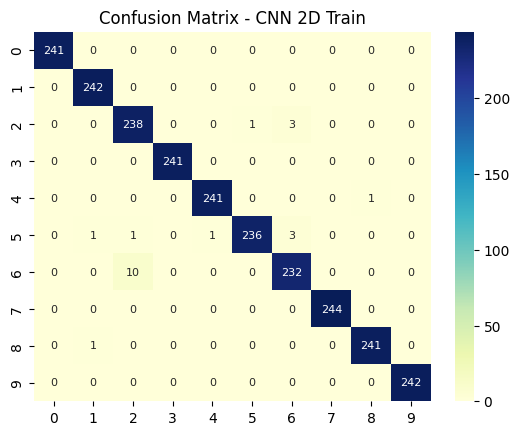

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


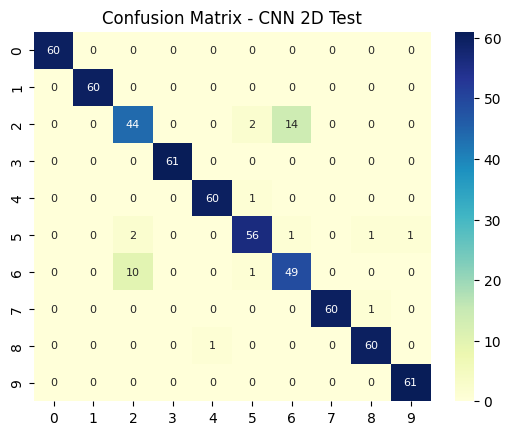

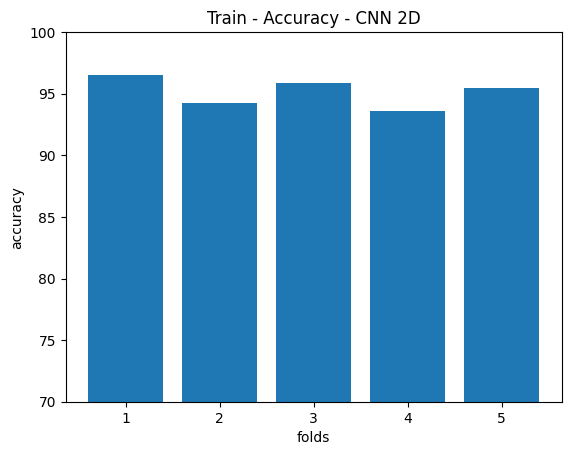

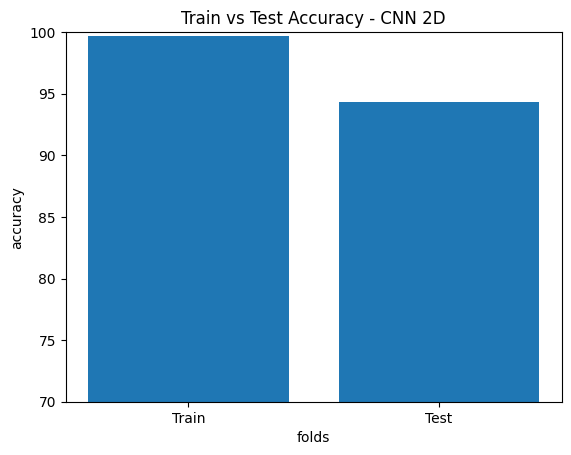

In [13]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Evaluation
# -----------------------------------------------------------------------------
"""

# Classification_2D.model.summary()

CNN_2D_train_accuracy = np.average(accuracy_train)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)
# print(accuracy_train)

CNN_2D_val_accuracy = np.average(accuracy_val)*100
print('CNN 2D validation accuracy =', CNN_2D_val_accuracy)
# print(accuracy_val)

CNN_2D_test_accuracy = np.average(accuracy_test)*100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)
# print(accuracy_test)

# Evaluate the accuracy of the model on the test set
# CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
# CNN_2D_test_accuracy*=100
# print('CNN 2D test accuracy =', CNN_2D_test_accuracy)


def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

# Plot results - CNN 2D
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

In [96]:
from tensorflow.keras.models import load_model

# for i in range(1, 6):
#     filepath = f"CNN2D_results/V4_2_NOL_exp1/best_model_{i}.h5"
#     print(f"\nModel summary for fold {i}:")
#     model = load_model(filepath)
#     model.summary()
#     for i, layer in enumerate(model.layers):
#         print(f"{i}: {layer.name} — {layer.output_shape}")


filepath = f"CNN2D_results/V4_2_NOL_exp1/best_model_1.h5"
print(f"\nModel summary for fold 1:")
model = load_model(filepath)
model.summary()
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name}")
    
model.predict(X_2D_test)
layer_name = 'conv2d_20'  
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)






Model summary for fold 1:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 40, 40, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 20, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_5 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,014 (851.62 KB)

 Trainable params: 218,012 (851.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

0: conv2d_20
1: max_pooling2d_20
2: conv2d_21
3: max_pooling2d_21
4: conv2d_22
5: max_pooling2d_22
6: conv2d_23
7: max_pooling2d_23
8: flatten_5
9: dense_15
10: dense_16
11: dense_17
12: softmax_5
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2025-06-05 14:23:37.746124: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 14:23:37.746996: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


AttributeError: The layer sequential_5 has never been called and thus has no defined input.